In [1]:
# Load Libraries - Make sure to run this cell!
import pandas as pd
import numpy as np
import re
import datetime 
from collections import Counter
from sklearn import feature_extraction, tree, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
from yellowbrick.features.rankd import Rank2D
from yellowbrick.features.radviz import RadViz
from yellowbrick.features.pcoords import ParallelCoordinates
from yellowbrick.features import JointPlotVisualizer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
import matplotlib.pyplot as plt
import matplotlib
import entropy
%matplotlib inline

# Useful cyber libraries
import whois   # pip install python-whois
import tldextract  # pip install tldextract 
import ipaddress  # pip install ipaddress
import dns.query  # pip install dnspython
import dns.resolver
from dns.exception import DNSException

<img src="../img/logo_white_bkg_small.png" align="right" />   


## Worksheet 5.1 - Feature Engineering: Malicious URL Detection using Machine Learning - Answers

This worksheet is a step-by-step guide on how to train a Machine Learning model that can detect malicious URLs. We will walk you through the process of transforming raw URL strings to Machine Learning features and creating a Decision Tree Classifer which you will use to determine whether a given URL is malicious or not. Once you have implemented the classifier, the worksheet will walk you through evaluating your model.  

### Overview 2 main steps:

1. **Feature Engineering** - from raw URL strings to features using [pandas](http://pandas.pydata.org/pandas-docs/stable/) DataFrame, datetime and [numpy](http://www.numpy.org/) manipulations.
2. **Machine Learning Classification** - predict whether a URL is malicious or not using a Decision Tree Classifier in [sklearn](http://scikit-learn.org/stable/) and evaluate model performance

We provide an additional notebook where you can see how to use "Featureless Deep Learning" to build such a classifier.


### Data

The dataset was build from various different open source data sources. Computationally intensive tasks such as retrieving the creation time for each unique domain in the data set via [whois](https://pypi.python.org/pypi/python-whois) have already been performed beforehand. Some of the open source URLs came with the zone apex only, others didn't include the protocol, therefore, we uniformly removed the protocol (http:// or https://) and subdomain (e.g. www) from the URL string if applicable.

Benign
- Custom automated webscraping of [Alexa Top 1M](https://blog.majestic.com/development/majestic-million-csv-daily/) with recursive depth of scraping of level 1.

Malicious
- Various blacklists
- [openphish](https://openphish.com/)
- [phishtank](https://www.phishtank.com/)
- [public GitHub faizann24](https://github.com/faizann24/Using-machine-learning-to-detect-malicious-URLs)
- some more sources

The dataset is perfectly balanced (50% benign and 50% malicious). We emphasized on getting benign URLs with paths and not just the domain. Furthermore, depending on your environment you can choose between a smaller subset (```url_data_small.csv``` containing 4000 URLs balanced) or the full data set (```url_data_full.csv``` containing 87380 URLs balanced).


In [2]:
## Load data
DATA_HOME = '../data/'
df = pd.read_csv(DATA_HOME + 'url_data_full.csv')
# df = pd.read_csv(DATA_HOME + 'url_data_small.csv')
df.isIP = df.isIP.astype(int)
print(df.shape)
df.sample(n=5).head() # print a random sample of the DataFrame

(87380, 5)


,url,isMalicious,domain,created,isIP
47368,manshutang.com/zhiovlon,1,manshutang.com,2013-12-27 01:51:54.000000,0
19605,hx2car.com/hengju,0,hx2car.com,2004-11-15 13:34:36.000,0
26649,marchofdimes.com/mission-stories/stacey-d-stew...,0,marchofdimes.com,1999-01-30 05:00:00.000,0
39788,hitslink.com/home/dashboarddemo?name=Social,0,hitslink.com,1999-11-14 00:00:00.000,0
59990,directxex.com/uploads/84937512.And.exe Win32/I...,1,directxex.com,2012-07-17 20:57:00.000,0


In [3]:
df['isMalicious'].value_counts()

1    43690
0    43690
Name: isMalicious, dtype: int64

## Part 1 - Feature Engineering


The traditional approach is to hand-craft Machine Learning features. This can be the most tedious part and often requires extensive domain expertise and data wrangling skills.

Previous academic research on identifying malicious or suspicious URLs has focused on studying the usefulness of an exhausted list of candidate features. Here, we cover only a selection of some basic and most widely used features.

There are 4 main "URL Features" families:
1. **BlackList Features**: Check if in any BlackList. BlackLists suffer from a high false negative rate, but can still be useful as a feature.
2. **Lexical Features**: Using methods from Natural Language Processing. They capture the property of malicious URLs tending to "look different" from benign URLs. Therefore, lexical features quantify contextual information such as the length of the URL.
3. **Host-based Features**: They quantify properties of the web site host and answer "where" the site is hosted, "who" owns it and "how" it is managed. API queries are needed for this type of features (WHOIS, DNS records). Some example features can be the date of registration, geolocation, autonomous system (AS) number, connection speed or time-to-live (TTL).
4. **Content-based Features**: This is one of the less commonly used feature families as it requires the download of the entire web-page, hence execution of the potential malicious site, which can not only be not safe, but also increases the computational cost of deriving features. Features here can be HTML or JavaScript based.

Source: Sahoo et al. 2017: [Malicious URL Detection using Machine Learning: A Survey](https://arxiv.org/pdf/1701.07179.pdf)

In this notebook, we focus on a selection of **lexical features** and **host-based features**, starting with the lexical ones in the subsequent code cell. The host-based features instructions will follow in the next markdown cell.

### Feature Engineering Sub-Section A - Lexical Features


**Selection of lexical features**:

1. Length of URL ["Length"]
2. Length of hostname/domain ["LengthDomain]
3. Count of digits ["DigitsCount"]
4. Entropy of hostname/domain ["EntropyDomain"] - use ```H_entropy``` function provided 
5. Position (or index) of the first digit ["FirstDigitIndex"] - use ```firstDigitIndex``` function provided 
6. Bag-of-words - more details later

We provide a couple of helper functions. Please run the following function cell and then continue reading the next markdown cell with more details on how to derive those features. Have fun!



In [4]:
def H_entropy (x):
    # Calculate Shannon Entropy
    return entropy.shannon_entropy(x)

def firstDigitIndex( s ):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

### Tasks - Sub-Section A - Lexical Features

Append features to the pandas 2D DataFrame ```df``` with a new column for each feature. Later, simply drop the columns that are not features. Please focus on ```["Length"]```, ```["LengthDomain]```, ```["DigitsCount"]```, ```["EntropyDomain"]``` and ```["FirstDigitIndex"]``` here. [pandas.Series.str](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.html), [pandas.Series.replace](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.replace.html) and [pandas.Series,apply](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.apply.html) and [tldextract](https://pypi.python.org/pypi/tldextract) can be very helpful to quickly derive those features. Functions you need to apply here are provided in above cell.

For the ```Bag-of-words``` see next instructions in next markdown cell...


In [5]:
# derive simple lexical features
df['Length'] = df.url.str.len()
df['LengthDomain'] = df.domain.str.len()
df['DigitsCount'] = df.url.str.count('[0-9]')
df['EntropyDomain'] = df.domain.apply(H_entropy)
df['FirstDigitIndex'] = df.url.apply(firstDigitIndex)

# check intermediate 2D pandas DataFrame
print(len(df.columns))
df.sample(n=5)

10


,url,isMalicious,domain,created,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex
12582,alertnet.org/item/20170317180341-8hc5v,0,alertnet.org,1997-04-04 05:00:00.000,0,38,12,16,0.385620,19
76232,ulmicsulfa.net/fm32yz2,1,ulmicsulfa.net,2016-11-20 00:00:00.000,0,22,14,3,0.440205,18
58469,gemusbagages.com/fykj15tk,1,gemusbagages.com,2014-03-22 00:00:00.000000,0,25,16,2,0.400352,22
20324,yahoo.com/news/interview-help-writer-director-...,0,yahoo.com,1995-01-18 00:00:00.000,0,72,9,9,0.330201,59
62029,lynked.com/ourtime.com/wwwourtimecom.html,1,lynked.com,2000-02-13 00:00:00.000000,0,41,10,0,0.415241,0


### Tasks - Sub-Section A - Lexical Features (continued)

There are many different approaches of applying ```bag-of-words``` to URLs. Here we suggest the following approach:

1. Extract the different portions of the URL (host names (domains), top-level-domains (tlds) [what is TLD](https://en.wikipedia.org/wiki/Top-level_domain), paths) and create separate pandas Series (or Python lists) using the [tldextract](https://pypi.python.org/pypi/tldextract) library.
2. (Code for step 2 is provided) Find the top 20 tlds (e.g. ```com```, ```de```, ```ru``` etc) from the data. Then use [sklearn CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to create ```bag-of-words``` with a custom vocabulary, here the top 20 tlds as parameter input. Use the ```.fit()``` method to train the CountVectorizer model (save the model in a variable, you will need this model later for real-time transformations of new URLs). After this the ```.transform()``` function is applied to the pandas Series or list of tlds. The resulting matrix is dense, therefore ```.toarray()``` is needed to get a regular numpy matrix. You will notice that this numpy matrix is very sparse, that is, contains a lot of zeros. The ```get_feature_names()``` is useful to get not only the vocabulary, but also to know which column of the matrix corresponds to which ```word```.
3. Knowing procedures for step 2, please try to do something similar for the domains. However, choose an ```ngram``` approach via setting the following parameters for the CountVectorizer: ```analyzer='char', ngram_range=(3, 4), max_features=30```.
4. (Code for step 4 is provided) Again, we provide you with the solution to applying a different CountVectorizer approach to the path using ```analyzer='word', tokenizer=custom_path_tokenizer, max_features=100``` as parameters.
5. Feel free to try different approaches.

At each step the numpy matrix is converted to a pandas DataFrame and then concatenated to the previous one and so on. That way you can run one cell multiple times without re-concatenating to the original df which would throw errors. At the end simply replace the original df with the df that contains all bag-of-words features.


In [6]:
def extract_path(url):
    return re.sub('.'.join([tldextract.extract(url).domain, tldextract.extract(url).suffix]), '', url)

In [7]:
domains = df.url.apply(lambda x: tldextract.extract(x).domain)
tlds = df.url.apply(lambda x: tldextract.extract(x).suffix)
paths = df.url.apply(extract_path)

In [8]:
n_tlds = 20
top_tlds = list(tlds.value_counts().head(n_tlds).keys())
top_tlds = [tld if tld is not '' else 'nan' for tld in top_tlds]  # encode empty/missing tld as 'nan'

In [9]:
CountVectorizer_tlds = CountVectorizer(analyzer='word', vocabulary=top_tlds)
CountVectorizer_tlds = CountVectorizer_tlds.fit(tlds)
matrix_dense_tlds = CountVectorizer_tlds.transform(tlds)

print(CountVectorizer_tlds.get_feature_names())
print(matrix_dense_tlds.shape)
print(sum(matrix_dense_tlds.toarray()))

['com', 'org', 'net', 'ru', 'co.uk', 'info', 'fr', 'biz', 'pl', 'top', 'us', 'cc', 'pt', 'tv', 'co.kr', 'su', 'ws', 'org.uk', 'club', 'pro']
(87380, 20)
[65135  6699  5198  3750     0  1136   901   427   430   345   340   214
   183   147     0   135    90     0    77    66]


In [10]:
df_tlds = pd.DataFrame(matrix_dense_tlds.toarray(), columns=CountVectorizer_tlds.get_feature_names())
# matrix_dense_tlds.toarray() converts dense matrix to a regular matrix, which will be sparse (a lot of zeros)
df1 = pd.concat([df, df_tlds],axis=1)
print(len(df1.columns))
df1.head()

30


,url,isMalicious,domain,created,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,...,us,cc,pt,tv,co.kr,su,ws,org.uk,club,pro
0,evenue.net/cgi-bin/ncommerce3/SEGetGroupList?g...,0,evenue.net,1998-12-03 00:00:00.000,0,331,10,112,0.290241,29,...,0,0,0,0,0,0,0,0,0,0
1,nudography.com/Celebrities/saira_mohan.aspx,0,nudography.com,2002-11-15 00:00:00.000,0,43,14,0,0.458062,0,...,0,0,0,0,0,0,0,0,0,0
2,youtube.com/watch?v=y4JFnHP0pbs,0,youtube.com,2005-02-14 21:13:12.000,0,31,11,2,0.386974,22,...,0,0,0,0,0,0,0,0,0,0
3,sketchthemes.com/pricing,0,sketchthemes.com,2011-07-04 22:49:45.000,0,24,16,0,0.384727,0,...,0,0,0,0,0,0,0,0,0,0
4,promodj.com/valentineblack/radioshows/6257088/...,0,promodj.com,2004-12-02 19:02:13.000,0,94,11,18,0.355669,39,...,0,0,0,0,0,0,0,0,0,0


In [11]:
CountVectorizer_domains = CountVectorizer(analyzer='char', ngram_range=(3, 4), max_features=30)
CountVectorizer_domains = CountVectorizer_domains.fit(domains)

matrix_dense_domains = CountVectorizer_domains.transform(domains)

df_domains = pd.DataFrame(matrix_dense_domains.toarray(), columns=CountVectorizer_domains.get_feature_names())
df2 = pd.concat([df1, df_domains],axis=1)
print(len(df2.columns))
df2.head()

60


,url,isMalicious,domain,created,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,...,res,sta,ste,ter,the,tio,tion,tor,tra,ver
0,evenue.net/cgi-bin/ncommerce3/SEGetGroupList?g...,0,evenue.net,1998-12-03 00:00:00.000,0,331,10,112,0.290241,29,...,0,0,0,0,0,0,0,0,0,0
1,nudography.com/Celebrities/saira_mohan.aspx,0,nudography.com,2002-11-15 00:00:00.000,0,43,14,0,0.458062,0,...,0,0,0,0,0,0,0,0,0,0
2,youtube.com/watch?v=y4JFnHP0pbs,0,youtube.com,2005-02-14 21:13:12.000,0,31,11,2,0.386974,22,...,0,0,0,0,0,0,0,0,0,0
3,sketchthemes.com/pricing,0,sketchthemes.com,2011-07-04 22:49:45.000,0,24,16,0,0.384727,0,...,0,0,0,0,1,0,0,0,0,0
4,promodj.com/valentineblack/radioshows/6257088/...,0,promodj.com,2004-12-02 19:02:13.000,0,94,11,18,0.355669,39,...,0,0,0,0,0,0,0,0,0,0


In [12]:
def custom_path_tokenizer(path):  # input is a string for one path from one URL
    return list(filter(None, re.compile('[\?\=/\._-]').split(path.lower())))

In [13]:
CountVectorizer_paths = CountVectorizer(analyzer='word', tokenizer=custom_path_tokenizer, max_features=100)
CountVectorizer_paths = CountVectorizer_paths.fit(paths)

matrix_dense_paths = CountVectorizer_paths.transform(paths)

df_paths = pd.DataFrame(matrix_dense_paths.toarray(), columns=CountVectorizer_paths.get_feature_names())
df3 = pd.concat([df2, df_paths],axis=1)
print(len(df3.columns))
df3.head()

160


,url,isMalicious,domain,created,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,...,us,user,v,video,view,web,websc,wiki,wp,www
0,evenue.net/cgi-bin/ncommerce3/SEGetGroupList?g...,0,evenue.net,1998-12-03 00:00:00.000,0,331,10,112,0.290241,29,...,0,0,0,0,0,0,0,0,0,0
1,nudography.com/Celebrities/saira_mohan.aspx,0,nudography.com,2002-11-15 00:00:00.000,0,43,14,0,0.458062,0,...,0,0,0,0,0,0,0,0,0,0
2,youtube.com/watch?v=y4JFnHP0pbs,0,youtube.com,2005-02-14 21:13:12.000,0,31,11,2,0.386974,22,...,0,0,1,0,0,0,0,0,0,0
3,sketchthemes.com/pricing,0,sketchthemes.com,2011-07-04 22:49:45.000,0,24,16,0,0.384727,0,...,0,0,0,0,0,0,0,0,0,0
4,promodj.com/valentineblack/radioshows/6257088/...,0,promodj.com,2004-12-02 19:02:13.000,0,94,11,18,0.355669,39,...,0,0,0,0,0,0,0,0,0,0


### Feature Engineering Sub-Section B - Host-based Features


Derivation of host-based features often requires the use of APIs or querying information from some authoritative source. It took us 2 days to get all whois data for all of our unique domains (see ```domains_created_db.csv``` file). 

**Selection of host-based features**:

1. Time delta between today's date and creation date ['DurationCreated'] (original whois code included at the end of the notebook)
2. Check if it is an IP address ['isIP'] - already provided, no feature engineering needed   
3. (Time-to-live ['ttl'] - code to query an authoritative nameserver included at the end of the notebook, but not included in preprocessed data set)


### Tasks - Sub-Section B - Host-based Features

Append features to the pandas 2D DataFrame ```df``` with a new column for each feature. Later, simply drop the columns that are not features. [pandas.to_datetime](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) with ```errors='coerce'``` is easy to use to convert the ```WHOIS``` info ```["created"]``` to a datetime data type. Make sure to also fillna with zeros! You can then simply subtract the creation date from today's date to derive the ```["DurationCreated"]``` feature. [pandas.Series.dt.day](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.dt.day.html) can be handy to express the time delta in days. 

After all features have been added to the pandas 2D DataFrame, please drop all columns that are not features etc, here drop ```['url', 'created', 'domain']```.


In [14]:
df=df3
df.created = pd.to_datetime(df.created, errors='coerce')
df['DurationCreated'] = (pd.to_datetime(datetime.date.today()) - df.created).dt.days

# check final 2D pandas DataFrame containing all final features and the target vector isMalicious
df.sample(n=5).head()

,url,isMalicious,domain,created,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,...,user,v,video,view,web,websc,wiki,wp,www,DurationCreated
59868,dropboxusercontent.com/s/fw92fsu9r694iqc/Qatif...,1,dropboxusercontent.com,2012-01-13 15:35:09,0,54,22,6,0.455156,28,...,0,0,0,0,0,0,0,0,0,2656
24383,linkedin.com/pub/dir/Richard/Markoff,0,linkedin.com,2002-11-02 07:38:11,0,36,12,0,0.406454,0,...,0,0,0,0,0,0,0,0,0,6015
17921,rumormillnews.com/cgi-bin/forum.cgi?noframes;r...,0,rumormillnews.com,1998-06-09 00:00:00,0,55,17,5,0.431853,51,...,0,0,0,0,0,0,0,0,0,7623
81885,pineysprat.com/jd3gfy,1,pineysprat.com,2016-11-22 17:39:18,0,21,14,1,0.458062,18,...,0,0,0,0,0,0,0,0,0,881
24720,operationsmile.org/act-now/volunteer,0,operationsmile.org,1996-02-22 05:00:00,0,36,18,0,0.446554,0,...,0,0,0,0,0,0,0,0,0,8460


In [15]:
df_final = df
df_final = df_final.drop(['url', 'domain', 'created'], axis=1)
df_final.to_csv(DATA_HOME + 'url_features_final_df.csv', index=False)
df_final.sample(n=5).head()

,isMalicious,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,com,org,net,...,user,v,video,view,web,websc,wiki,wp,www,DurationCreated
26203,0,0,25,15,0,0.438361,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3281
36925,0,0,49,20,0,0.448023,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2853
25665,0,0,42,6,0,0.323120,0,1,0,0,...,0,0,0,0,0,0,0,0,0,8796
21727,0,0,34,8,7,0.375000,2,0,0,1,...,0,0,0,0,0,0,0,0,0,5051
84311,1,0,28,18,1,0.413534,20,1,0,0,...,0,0,0,0,0,0,0,0,0,3378


In [16]:
# PySpark can't handle colNames with dots, Therefore let's export a modified version
df_spark = df_final
newColNames = [x.replace(".", "") for x in df_final.columns]
df_spark.columns = newColNames
df_spark.to_csv(DATA_HOME + 'url_features_final_df_spark.csv', index=False)
df_spark.sample(n=5).head()

,isMalicious,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,com,org,net,...,user,v,video,view,web,websc,wiki,wp,www,DurationCreated
20945,0,0,38,9,7,0.368463,17,1,0,0,...,0,0,0,0,0,0,0,0,0,7646
48770,1,0,57,26,0,0.447558,0,1,0,0,...,0,0,0,0,0,0,0,0,0,3597
76006,1,0,73,18,0,0.451796,0,1,0,0,...,0,0,0,0,0,0,0,0,0,961
36512,0,0,71,13,0,0.424093,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7822
34348,0,0,77,8,8,0.343750,16,1,0,0,...,0,0,0,0,0,0,0,0,0,8427


#### Breakpoint: Load Features and Labels

If you got stuck in Part 1, please simply load the feature matrix we prepared for you, so you can move on to Part 2 and train a Decision Tree Classifier.

In [17]:
df_final = pd.read_csv(DATA_HOME + 'url_features_final_df.csv')
print(df_final.isMalicious.value_counts())
print(len(df_final.columns))
df_final.sample(n=5).head()

1    43690
0    43690
Name: isMalicious, dtype: int64
158


,isMalicious,isIP,Length,LengthDomain,DigitsCount,EntropyDomain,FirstDigitIndex,com,org,net,...,user,v,video,view,web,websc,wiki,wp,www,DurationCreated
7920,0,0,22,9,6,0.368463,17,0,0,0,...,0,0,0,0,0,0,0,0,0,7439
30488,0,0,100,9,13,0.312907,66,1,0,0,...,0,0,0,0,0,0,0,0,0,9065
27511,0,0,20,13,0,0.462555,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4788
28581,0,0,24,10,0,0.365241,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1590
4604,0,0,39,16,0,0.415977,0,1,0,0,...,0,0,1,0,0,0,0,0,0,8759


In [18]:
feature_names = list(df_final.columns)
feature_names.remove('isMalicious')

In [19]:
# Pickle certain variables, so they can be loaded again in part 2 to make new predictions
# feature_names, CountVectorizer_tlds, CountVectorizer_domains, CountVectorizer_paths
from six.moves import cPickle as pickle

tmp_models = {"feature_names":feature_names, "CountVectorizer_tlds":CountVectorizer_tlds, 
              "CountVectorizer_domains":CountVectorizer_domains, "CountVectorizer_paths":CountVectorizer_paths}

for key, value in tmp_models.items():

    with open(DATA_HOME + key + '.pickle', 'wb') as f:
            pickle.dump(value, f)
            
#     with open(DATA_HOME + key + '.pickle', 'rb') as f:
#             tmp_model = pickle.load(f)
#     print(tmp_model)

In [20]:
import dns.query
import dns.resolver
from dns.exception import DNSException

def query_authoritative_ns (domain, log=lambda msg: None, ttl_only=True):

    default = dns.resolver.get_default_resolver()
    ns = default.nameservers[0]

    n = domain.split('.')

    for i in range(len(n), 0, -1):
        sub = '.'.join(n[i-1:])

        log('Looking up %s on %s' % (sub, ns))
        query = dns.message.make_query(sub, dns.rdatatype.NS)
        response = dns.query.udp(query, ns)

        rcode = response.rcode()
        if rcode != dns.rcode.NOERROR:
            if rcode == dns.rcode.NXDOMAIN:
                raise Exception('%s does not exist.' % (sub))
            else:
                raise Exception('Error %s' % (dns.rcode.to_text(rcode)))

        if len(response.authority) > 0:
            rrsets = response.authority
        elif len(response.additional) > 0:
            rrsets = [response.additional]
        else:
            rrsets = response.answer

        # Handle all RRsets, not just the first one
        for rrset in rrsets:
            for rr in rrset:
                if rr.rdtype == dns.rdatatype.SOA:
                    print('Same server is authoritative for %s' % (sub))
                elif rr.rdtype == dns.rdatatype.A:
                    ns = rr.items[0].address
                    print('Glue record for %s: %s' % (rr.name, ns))
                elif rr.rdtype == dns.rdatatype.NS:
                    authority = rr.target
                    ns = default.query(authority).rrset[0].to_text()
                    print('%s [%s] is authoritative for %s; ttl %i' % (authority, ns, sub, rrset.ttl))
                    result = rrset
                    if ttl_only:
                        print(rrset)
                        result = rrset.ttl
                else:
                    # IPv6 glue records etc
                    #log('Ignoring %s' % (rr))
                    pass

    return result

In [21]:
query_authoritative_ns('www.gtkcyber.com')

m.gtld-servers.net. [192.55.83.30] is authoritative for com; ttl 169092
com. 169092 IN NS m.gtld-servers.net.
com. 169092 IN NS h.gtld-servers.net.
com. 169092 IN NS k.gtld-servers.net.
com. 169092 IN NS a.gtld-servers.net.
com. 169092 IN NS d.gtld-servers.net.
com. 169092 IN NS f.gtld-servers.net.
com. 169092 IN NS j.gtld-servers.net.
com. 169092 IN NS b.gtld-servers.net.
com. 169092 IN NS e.gtld-servers.net.
com. 169092 IN NS c.gtld-servers.net.
com. 169092 IN NS l.gtld-servers.net.
com. 169092 IN NS g.gtld-servers.net.
com. 169092 IN NS i.gtld-servers.net.
h.gtld-servers.net. [192.54.112.30] is authoritative for com; ttl 169092
com. 169092 IN NS m.gtld-servers.net.
com. 169092 IN NS h.gtld-servers.net.
com. 169092 IN NS k.gtld-servers.net.
com. 169092 IN NS a.gtld-servers.net.
com. 169092 IN NS d.gtld-servers.net.
com. 169092 IN NS f.gtld-servers.net.
com. 169092 IN NS j.gtld-servers.net.
com. 169092 IN NS b.gtld-servers.net.
com. 169092 IN NS e.gtld-servers.net.
com. 169092 IN NS c

21600

In [26]:
whois.query('gtkcyber.com').creation_date

datetime.datetime(2017, 1, 20, 3, 32, 35)

##  Visualizing the Features
In the last step, you're going to explore the feature space to see which features are potentially useful or not and of course whether there is too much noise to make predictions.  

First, using [Yellowbrick](http://pythonhosted.org/yellowbrick/examples/examples.html), create a Covariance ranking of the features.  Since this section is about visualizing this information and not deriving it, please execute the cell below so that everyone will have the same data and get the same results.

In [27]:
## Load data
DATA_HOME = '../data/'
df_final = pd.read_csv(DATA_HOME + 'url_features_final_df.csv')
features = df_final.loc[:,'isIP':]
target = df_final['isMalicious']

/Users/cgivre/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()


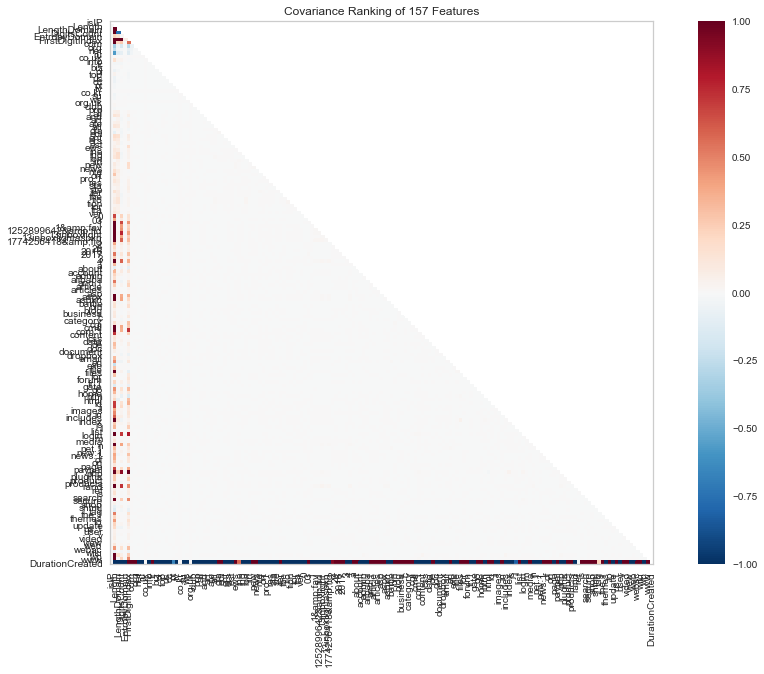

In [28]:
visualizer = Rank2D(features=features.columns, algorithm='covariance')
plt.figure(figsize=(16,10))

visualizer.fit(features, target)                # Fit the data to the visualizer
visualizer.transform(features)             # Transform the data
visualizer.poof()    # Draw/show/poof the data

### What did you see?
If you did this correctly, you should see that most of the features are nearly useless. Next, pick 7 features yourself, either using the `feature_selection` functions in `scikit-learn` or by just picking them yourself, and create a pair plot using Seaborn to determine whether there are clear class boundaries between the classes in these features. 

In [29]:
#Gets an arrary of the best features in 1 step.
best_features = SelectKBest( score_func=chi2, k=7).fit_transform(features,target)

#Get the feature names and indexes
best = SelectKBest( score_func=chi2, k=7).fit(features,target)
feature_names = pd.Series(features.columns)
feature_names[best.get_support()]

1               Length
2         LengthDomain
3          DigitsCount
119              login
130                php
154                 wp
156    DurationCreated
dtype: object

/Users/cgivre/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/cgivre/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/cgivre/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


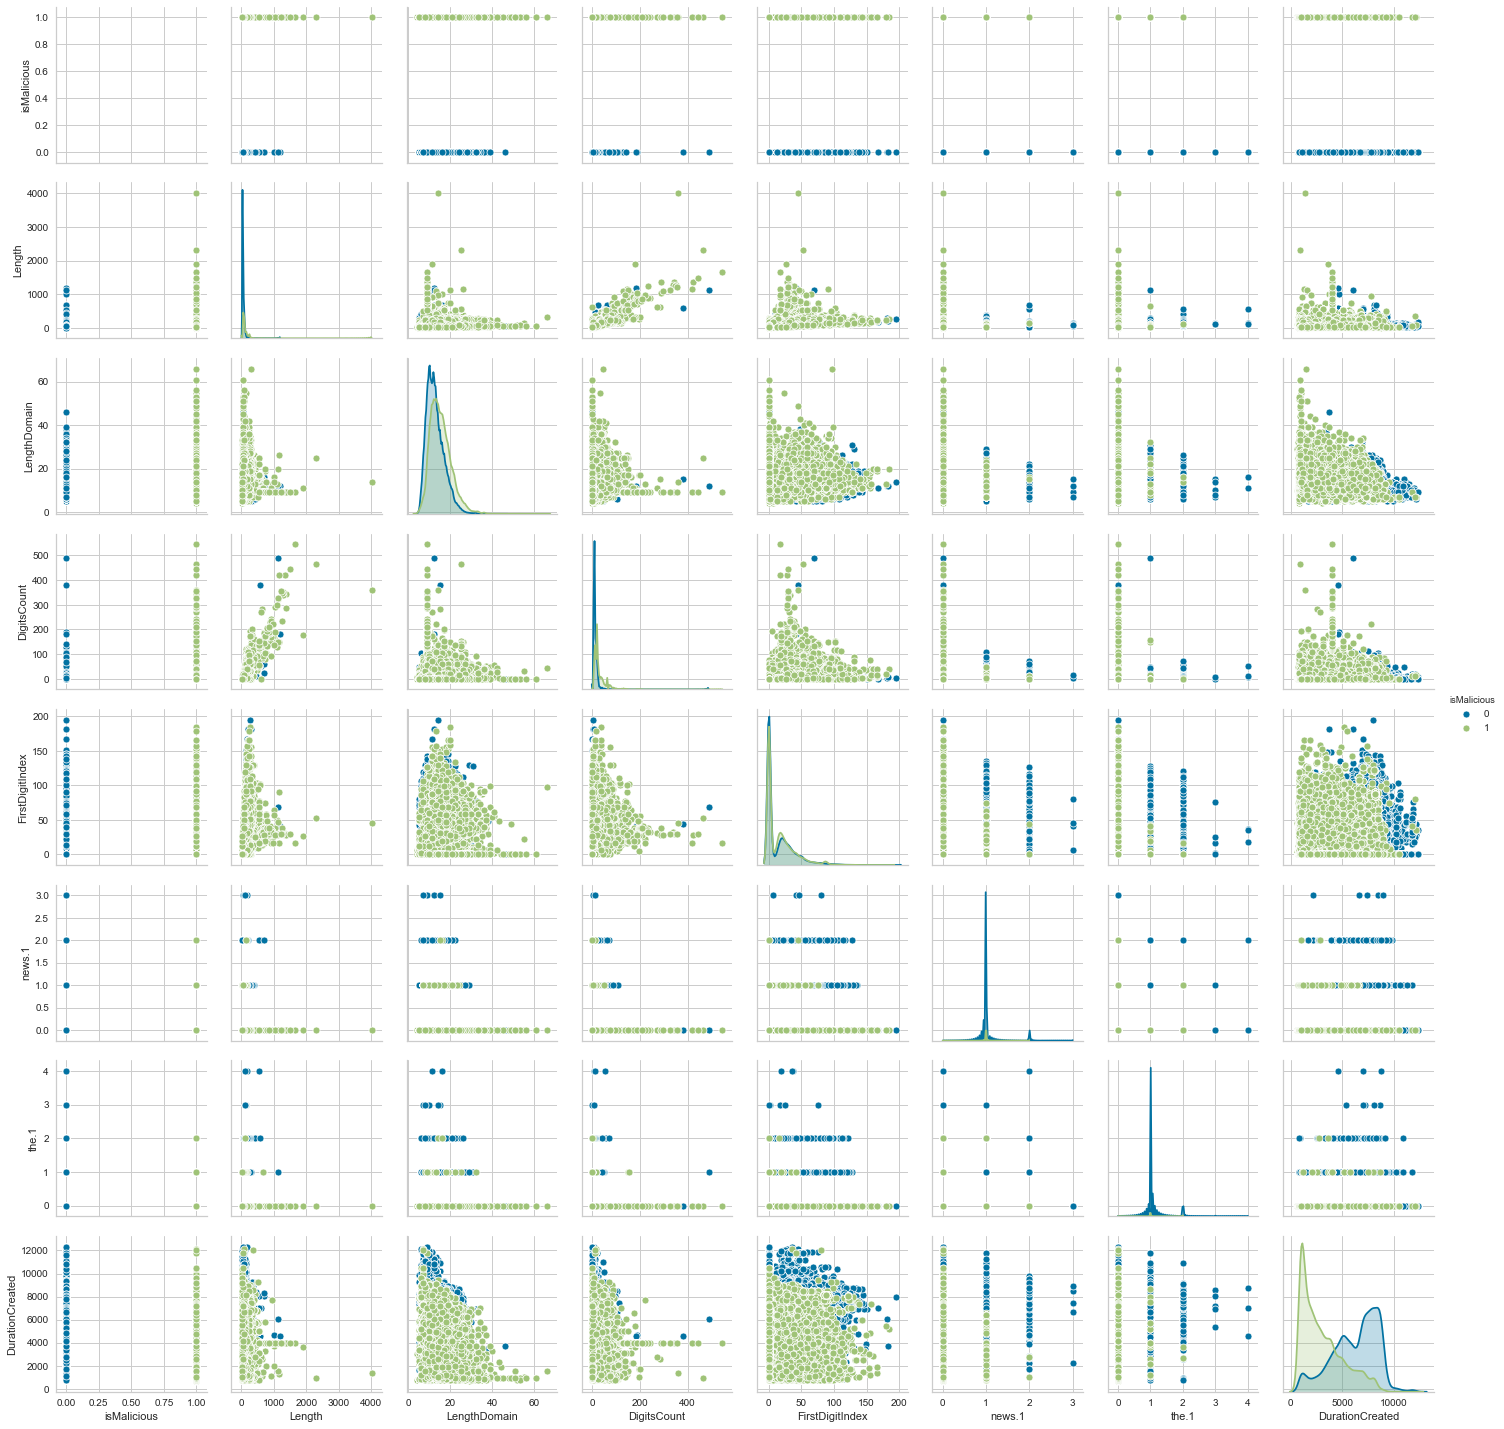

In [30]:
sns.pairplot(df_final[['isMalicious','Length',  'LengthDomain','DigitsCount', 'FirstDigitIndex', 'news.1', 'the.1', 'DurationCreated']], hue='isMalicious' )